In [1]:
from NIX_Testing import NIX_Image_List, NIX_Image
from pylab import *
from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize

import numpy.fft as nfft




In [2]:
def median_smooth(image):
    
    szx, szy = image.shape[0], image.shape[1]
    ims = zeros([szx, szy, 8])
    ims[:,:,0] = roll(image, 1, axis=0)
    ims[:,:,1] = roll(image, 1, axis=1)
    ims[:,:,2] = roll(image, -1, axis=0)
    ims[:,:,3] = roll(image, -1, axis=1)
    ims[:,:,4] = roll(roll(image, 1, axis=1), 1, axis=0)
    ims[:,:,5] = roll(roll(image, 1, axis=1), -1, axis=0)
    ims[:,:,6] = roll(roll(image, -1, axis=1), 1, axis=0)
    ims[:,:,7] = roll(roll(image, -1, axis=1), -1, axis=0)
    ims[0,:,0] = np.NaN
    ims[:,0,1] = np.NaN
    ims[-1,:,2] = np.NaN
    ims[:,-1,3] = np.NaN
    ims[:,0,4] = np.NaN
    ims[0,:,4] = np.NaN
    ims[:,0,5] = np.NaN
    ims[-1,:,5] = np.NaN
    ims[:,-1,6] = np.NaN
    ims[0,:,6] = np.NaN
    ims[:,-1,7] = np.NaN
    ims[-1,:,7] = np.NaN
    
    image = nanmedian(ims, axis=2)
    
    return image
    
def chan_stack(image):
    out = zeros([2048, 64, 32])
    for i in range(32):
        out[:,:,i] = image[:,64*i:64*(i+1)]
    return out

def chan_merge(image):
    out = zeros([2048, 2048])
    for i in range(32):
        out[:,64*i:64*(i+1)] = image[:,:,i]
    return out

def clean_im(image, fft_imc, ys, mark_sz):
    
    XX = arange(mark_sz)-(mark_sz-1)/2
    XX, YY = meshgrid(XX, XX)

    mark_sz2 = mark_sz**2
    
    n = len(ys)
    Xm, Ym = zeros([int(mark_sz2)*n]).astype(int), zeros([int(mark_sz2)*n]).astype(int)
    for i in range(n):
        Xm[i*mark_sz2:(i+1)*mark_sz2] = ys[i] + YY.flatten()
        Ym[i*mark_sz2:(i+1)*mark_sz2] = 0 + XX.flatten()
    
    fft_imc[Xm, Ym,:] = 0
    im_clean = real(nfft.ifft2(fft_imc, axes=(0,1)))
    
    return chan_merge(im_clean), im-chan_merge(im_clean)

In [3]:
BP_Mask = NIX_Image('BP_mask.fits')
data_dir = '/home/ydallilar/Documents/NIX/nixDetBackup/PER-124/PER-124-04-1/'
#data_dir = '/home/ydallilar/Documents/NIX/nixDetBackup/strehlTestFrames/'
#data_dir = '/home/ydallilar/Documents/NIX/nixDetBackup/FUN-040/FUN-040-01-1-a/'
NIX_GL = NIX_Image(data_dir + "ERIS_NIX_TEC_LABGAINLINEARITY239_0017.fits")
#NIX_GL = NIX_Image(data_dir + "ERIS_NIXIMG_TEC_LABTEST319_0074.fits")
#NIX_GL = NIX_Image(data_dir + "ERIS_NIX_CAL_DARKS225_0025.fits")
im = NIX_GL.getImage(mask=BP_Mask)
fits.PrimaryHDU(im).writeto('out/pickup/clean.fits', overwrite=True)

In [4]:
fft_im = nfft.fft2(im)
psd_im = absolute(fft_im)**2

In [5]:
fits.PrimaryHDU(psd_im).writeto('out/pickup/fullPSD.fits', overwrite=True)

[ 61.03515625 337.21923828 352.47802734 376.89208984 502.01416016]


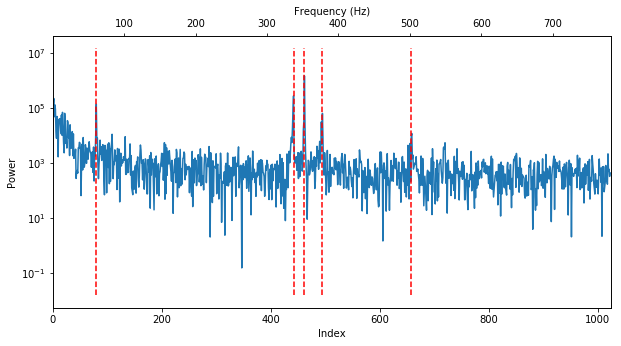

In [6]:
im_chan = chan_stack(im)
fft_imc = zeros([2048, 64, 32])+0j
psd_imc = zeros([2048, 64, 32])
psd_s_imc = zeros([2048, 64, 32])

fft_imc = nfft.fft2(im_chan, axes=(0,1))
psd_imc = absolute(fft_imc)**2

for i in range(32):
    psd_s_imc[:,:,i] = median_smooth(psd_imc[:,:,i])
    
med_psd_chan = median((psd_imc - psd_s_imc)[:,:,:], axis=2) 

%matplotlib inline
figure(figsize=(10,5))
psd_1d = absolute(nfft.fft(median(im_chan[:,:,-1], axis=1))[1:])**2
freq = nfft.fftfreq(2048, 64/1e5)
plot(arange(1,1024), psd_1d[1:1024])

ys = [80, 442, 462, 494, 658]
for i in range(len(ys)):
    plot([ys[i], ys[i]], [min(psd_1d)/10., max(psd_1d)*10.], 'r--')

print freq[ys]
    
ylabel('Power')
xlabel('Index')
xlim([0, 1024])
ax = twiny()
ax.set_xticks(arange(1,8)*100*64/1e5*2048/1024)
ax.set_xticklabels(arange(1,8)*100)
ax.set_xlabel('Frequency (Hz)')

yscale('log')
savefig('out/pickup/psd1d.png')
show();

fits.PrimaryHDU(chan_merge(psd_imc)).writeto('out/pickup/chanPSD.fits', overwrite=True)
fits.PrimaryHDU((med_psd_chan-median(med_psd_chan))/std(med_psd_chan)).writeto('out/pickup/smooth_diff.fits', overwrite=True)    

(2048, 2048)


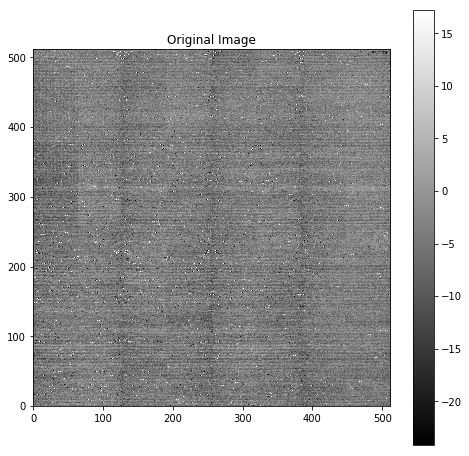

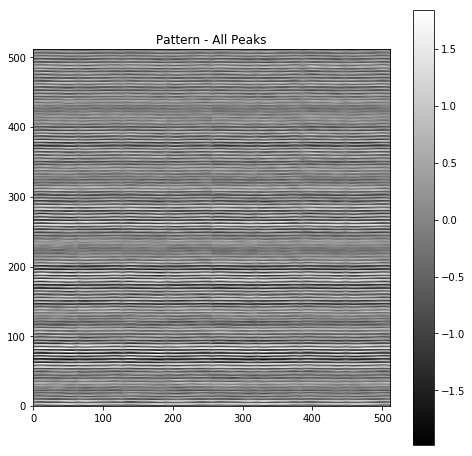

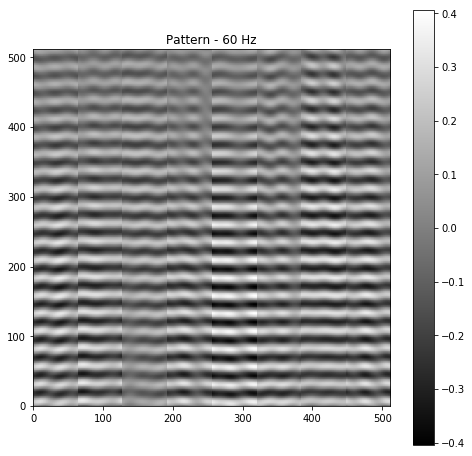

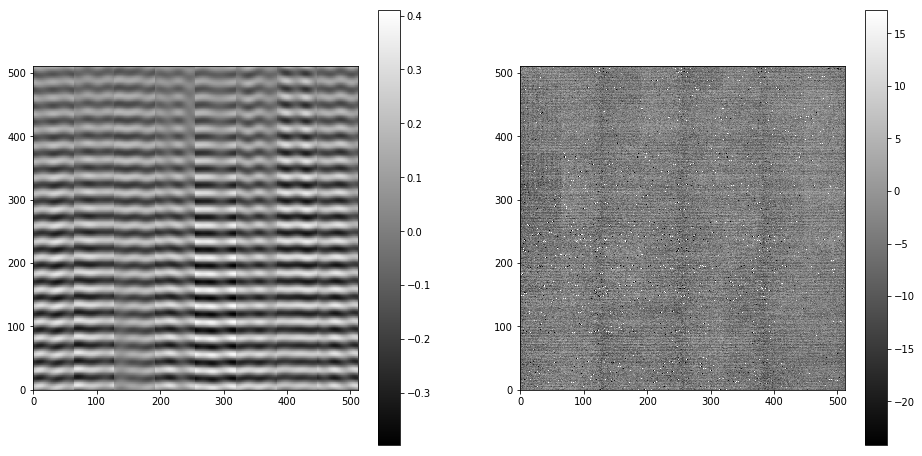

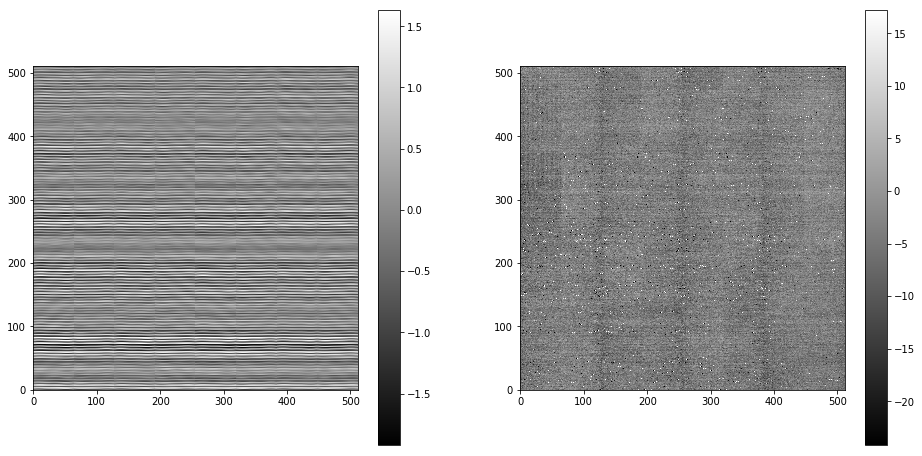

In [7]:
ys = [80]
im_clean, patt = clean_im(im, fft_imc, ys, 5)
ys = [80, 442, 462, 494, 658]
im_clean2, patt2 = clean_im(im, fft_imc, ys, 5)

zpatt = ImageNormalize(patt, interval=ZScaleInterval())
zpatt2 = ImageNormalize(patt2, interval=ZScaleInterval())
zim_clean = ImageNormalize(im_clean, interval=ZScaleInterval())


sl = slice(2048-64*8,2048)

print im_clean.shape
%matplotlib inline
figure(figsize=(8,8))
imshow(im[sl, sl], origin='lower', cmap='gray', norm=zim_clean)
title('Original Image')
colorbar()
savefig('out/pickup/orig.png')

figure(figsize=(8,8))
imshow(patt2[sl, sl], origin='lower', cmap='gray')
colorbar()
title('Pattern - All Peaks')
savefig('out/pickup/pattern_full.png')

figure(figsize=(8,8))
imshow(patt[sl, sl], origin='lower', cmap='gray')
colorbar()
title('Pattern - 60 Hz')
savefig('out/pickup/pattern_60Hz.png')


fig, ax = subplots(1,2, figsize=(16, 8))
plot = ax[0].imshow(patt[sl, sl], origin='lower', cmap='gray', norm=zpatt)
plot2 = ax[1].imshow(im_clean[sl, sl], origin='lower', cmap='gray', norm=zim_clean)
fig.colorbar(plot, ax=ax[0])
fig.colorbar(plot2, ax=ax[1])

#colorbar()

fig, ax = subplots(1,2, figsize=(16, 8))
plot = ax[0].imshow(patt2[sl, sl], origin='lower', cmap='gray', norm=zpatt2)
plot2 = ax[1].imshow(im_clean2[sl, sl], origin='lower', cmap='gray', norm=zim_clean)
fig.colorbar(plot, ax=ax[0])
fig.colorbar(plot2, ax=ax[1])

#colorbar()

#fits.PrimaryHDU(chan_merge(im_clean)).writeto('out/pickup/im_clean.fits', overwrite=True)
#fits.PrimaryHDU(im-chan_merge(im_clean)).writeto('out/pickup/pattern.fits', overwrite=True)
#fits.PrimaryHDU(im).writeto('out/pickup/orig.fits', overwrite=True)